In [40]:
# Uncomment and run to reload libs
# import importlib, utils
# importlib.reload(utils)
# import importlib, utils.modelling
# importlib.reload(utils.modelling)
# import importlib, utils.reader
# importlib.reload(utils.reader)
# import importlib, utils.miscellaneous
# importlib.reload(utils.miscellaneous)


import json
from multiprocessing import Pool, cpu_count

import pandas as pd
import torch
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

from utils import (
    logging,
    DUMMY_SEQ_NAMES_FILE,
    TRAINING_LOSSES_PLOT,
    MUTATION_SCORES_FILE,
)
from utils.modelling import Fixynergy, MutationDataset, MutationRecommender
from utils.reader import AminoAcidComboReader
from utils.miscellaneous import extract_AA


In [2]:
aa_combo_reader: AminoAcidComboReader = AminoAcidComboReader()
seq_mut = aa_combo_reader.before_date_data()


In [3]:
# Add 'Pos_id' for all sites
all_pos: pd.DataFrame = seq_mut[["Protein", "Pos"]].drop_duplicates()
all_pos = all_pos.sort_values(["Protein", "Pos"])
all_pos = all_pos.reset_index(drop=True)
all_pos.index = all_pos.index.set_names("Pos_id")
all_pos = all_pos.reset_index()
seq_mut = seq_mut.merge(all_pos, on=["Protein", "Pos"])

# Add 'Seq_id'
seq_info = pd.DataFrame(
    seq_mut["Accession"].unique(),
    columns=["Accession"]
)
seq_info["Seq_id"] = seq_info.index
seq_mut = seq_mut.merge(seq_info, on="Accession")
logging.info(f"{len(seq_mut.index)}")


In [4]:
dummy_seqs = seq_mut[["Protein", "To", "Pos", "Pos_id"]].drop_duplicates()
dummy_seqs["Mutation"] = dummy_seqs["Protein"] + "_" + dummy_seqs["Pos"].astype(str) + dummy_seqs["To"]
dummy_seq_names = list(dummy_seqs["Mutation"].values)

with open(DUMMY_SEQ_NAMES_FILE, "w") as f:
    json.dump(dummy_seq_names, f)

dummy_seqs[dummy_seqs["Pos"] == 614]


,Protein,To,Pos,Pos_id,Mutation
3,Spike,G,614,584,Spike_614G
569503,Spike,D,614,584,Spike_614D


In [5]:
seq_mut = pd.concat([
    seq_mut,
    pd.DataFrame({
        "Accession": dummy_seqs["Mutation"].values,
        "Lineage": "None",
        "Date": seq_mut["Date"].max(),
        "Seq_id": dummy_seqs["Pos_id"].values + len(seq_info["Seq_id"]),
        "Protein": dummy_seqs["Protein"],
        "Pos": dummy_seqs["Pos"].values,
        "To": dummy_seqs["To"].values,
        "Pos_id": dummy_seqs["Pos_id"].values
    })
])
logging.info(f"{len(seq_mut)} after dummy added")


In [6]:
seq_mut = seq_mut.rename(columns={"To": "AA_state"})
aa_table = seq_mut["AA_state"].unique()
aa_table.sort()
aa_table = pd.Series(aa_table)
aa_table.index.name = "AA_idx"
aa_table = aa_table.reset_index(name="AA_state")

seq_mut = seq_mut.merge(aa_table, on="AA_state")


In [7]:
use_cuda = torch.cuda.is_available()
# use_cuda = False
device = torch.device("cuda:0" if use_cuda else "cpu")
logging.info(f"Using device {device}")

n_factors = 10

batch_size = 128
shuffle = True
learning_rate = 1e-4
weight_decay = 1e-5
n_epochs = 100


In [8]:
training_data = MutationDataset(seq_mut)

model = MutationRecommender(
    n_seq=training_data.n_seq,
    n_pos=training_data.n_pos,
    n_factors=n_factors,
    n_states=training_data.n_states
)
model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay
)


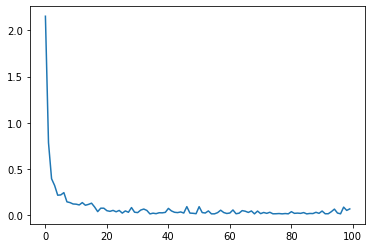

In [9]:
logging.info("Balance value..")
training_data.fill_underrepresented()

logging.info("Start training")

model.train()

losses = []
seq_ids: torch.Tensor
pos_ids: torch.Tensor
targets: torch.Tensor
pred: torch.Tensor
loss: torch.Tensor
for epoch in range(n_epochs):
    # training_data.balance_values()
    for (seq_ids, pos_ids), targets in DataLoader(
        training_data,
        batch_size=batch_size,
        shuffle=shuffle
    ):
        seq_ids = seq_ids.to(device)
        pos_ids = pos_ids.to(device)

        pred = model(seq_ids, pos_ids)
        targets = targets.to(device)
        # targets = targets.float().view(pred.size())
        loss: torch.Tensor = loss_fn(pred, targets.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    logging.info(f"{epoch + 1}/{n_epochs}, loss: {loss.item()}")
    losses.append({
        "epoch": epoch,
        "loss": loss.item()
    })

losses = pd.DataFrame.from_records(losses, index="epoch")

# plt.plot(losses[losses.index > n_epochs * 0.2]["loss"])
plt.plot(losses["loss"])
plt.savefig(TRAINING_LOSSES_PLOT)
logging.info(f"{TRAINING_LOSSES_PLOT} saved!")


In [11]:
logging.info("AA score matrix")

model.eval()

aa_mapping = dict(seq_mut[["AA_idx", "AA_state"]].drop_duplicates().values)
n_pos = len(training_data.pos_id2name)
aa_scores = []
with torch.no_grad():
    for seq_id, seq_name, protein_name in training_data.seq_id2name.itertuples():
        seq_ids = torch.Tensor(torch.Tensor([seq_id] * n_pos)).int().to(device)
        pos_ids = torch.Tensor(training_data.pos_id2name.index).int().to(device)
        pred: torch.Tensor = model(seq_ids, pos_ids)
        scores = pd.DataFrame(pred.data.cpu().numpy())
        scores = scores.rename(columns=aa_mapping)
        scores["Pos"] = training_data.pos_id2name["Pos"]
        scores["Accession"] = seq_name
        scores["Protein"] = protein_name
        aa_scores.append(scores)

aa_scores: pd.DataFrame = pd.concat(aa_scores).reset_index(drop=True)
aa_scores.to_feather(MUTATION_SCORES_FILE)
logging.info(f"{MUTATION_SCORES_FILE} saved!")


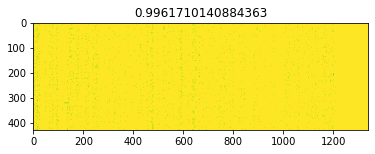

In [41]:
# The original amino acid per site per sequence
true_AA = seq_mut.loc[~seq_mut["Accession"].isin(dummy_seq_names)]
true_AA = true_AA[["Accession", "Protein", "Pos", "AA_state"]]
true_AA = true_AA.sort_values(["Accession", "Pos"])
true_AA = true_AA.reset_index(drop=True)

# Predicted amino acid scores per site per original sequence
pred_scores_original = aa_scores.loc[~aa_scores["Accession"].isin(
    dummy_seq_names)]
# One-hot encode of all amino acid
aa_names = list(aa_mapping.values())
# Convert scores to amino acid using one-hot encode
with Pool(cpu_count()) as p:
    pred_AA = p.starmap(
        func=extract_AA,
        iterable=((ac, ac_group, aa_names)
                  for ac, ac_group in pred_scores_original.groupby("Accession", sort=False))
    )
    pred_AA = pd.concat(pred_AA)
    pred_AA = pred_AA.sort_values(["Accession", "Pos"])
    pred_AA = pred_AA.reset_index(drop=True)

# Make sure 'Accession' and 'Pos' of all original sequences are in the prediction
assert all(true_AA["Accession"] == pred_AA["Accession"])
assert all(true_AA["Pos"] == pred_AA["Pos"])

# See if amino acid state of original sequences can be recovered
pred_true = true_AA["AA_state"] == pred_AA["AA_state"]
pred_true = pd.concat([true_AA["Accession"], true_AA["Pos"], pred_true], axis=1)

plt.imshow(
    pred_true.pivot_table(
        index="Accession",
        columns="Pos",
        values="AA_state",
        sort=False
    ),
)
plt.title(sum(pred_true["AA_state"]) / len(true_AA))
plt.show()
plt.close()
